In [154]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import os
from progressbar import progressbar as pbar
from earthtext.osm import osm
from joblib import delayed, Parallel
import sys

In [157]:
k = gpd.read_parquet("/opt/data/california-naip-chips/california-naip-chips-100k.parquet")
k

,date,chip_index_x,chip_index_y,cloud_cover_percentage,nodata_percentage,geometry,embeddings,original_chip_id
chip_id,,,,,,,,
363a8bd1189d2,2022-06-07,39,27,0.0,0.0,"POLYGON ((-118.87306 34.96546, -118.87303 34.9...","[-0.15684646, -0.012374564, 0.14199159, 0.0223...",ca_m_3411801_ne_11_060_20220607-39-27
2e40268e9f603,2022-06-07,17,29,0.0,0.0,"POLYGON ((-118.90999 34.96211, -118.90996 34.9...","[-0.14062901, 0.024275444, 0.14352247, 0.00669...",ca_m_3411801_ne_11_060_20220607-17-29
1ff73cff31463,2022-06-07,32,24,0.0,0.0,"POLYGON ((-118.88492 34.96943, -118.88489 34.9...","[-0.1360133, 0.01871811, 0.14964038, 0.0063366...",ca_m_3411801_ne_11_060_20220607-32-24
0fa44a50e26f3,2022-06-07,17,6,0.0,0.0,"POLYGON ((-118.91073 34.99395, -118.91070 34.9...","[-0.15236035, 0.020283332, 0.15849304, 0.01576...",ca_m_3411801_ne_11_060_20220607-17-6
10164c9de3dbc,2022-06-07,24,10,0.0,0.0,"POLYGON ((-118.89883 34.98860, -118.89879 34.9...","[-0.0994814, 0.021638228, 0.059680425, -0.0212...",ca_m_3411801_ne_11_060_20220607-24-10
...,...,...,...,...,...,...,...,...
139d06c9ad49a,2022-05-01,33,0,0.0,0.0,"POLYGON ((-117.19488 35.43942, -117.19488 35.4...","[-0.14007863, 0.027444532, 0.15230183, 0.00352...",ca_m_3511739_sw_11_060_20220501-33-0
1f1d514789561,2022-05-01,29,3,0.0,0.0,"POLYGON ((-117.20164 35.43525, -117.20164 35.4...","[-0.14104775, 0.025011389, 0.1589857, 0.019384...",ca_m_3511739_sw_11_060_20220501-29-3
2297da4bc0278,2022-05-01,16,21,0.0,0.0,"POLYGON ((-117.22357 35.41028, -117.22357 35.4...","[-0.13999236, 0.023521734, 0.1541872, -0.01373...",ca_m_3511739_sw_11_060_20220501-16-21


# gather all areas and lengths of all tags

In [4]:
osm_folder = "/opt/data/california-naip-chips/osm"

In [5]:
osm_files = os.listdir(osm_folder)
len(osm_files)

112320

In [6]:
class mParallel(Parallel):
    """
    substitutes joblib.Parallel with richer verbose progress information
    """
    def _print(self, msg):
        if self.verbose > 10:
            fmsg = '[%s]: %s' % (self, msg)
            sys.stdout.write('\r ' + fmsg)
            sys.stdout.flush()

In [109]:
z = gpd.read_parquet(f"{osm_folder}/{osm_files[0]}")
z

,tags,geometry,kind,length,area,stags,chip_id
395,{'highway': 'track'},"LINESTRING (-118.87340 34.96407, -118.87340 34...",way,153.686518,0.00000,highway: track,363a8bd1189d2
2512,{'landuse': 'farmland'},"POLYGON ((-118.87471 34.96405, -118.87474 34.9...",way,546.919208,18671.53543,landuse: farmland,363a8bd1189d2


In [110]:
def get_tag_stats(osm_file):
    tag_stats = {}
    z = gpd.read_parquet(f"{osm_folder}/{osm_file}")
    for _,row in z.iterrows():
        if row['kind']!='way':
            continue
        tags = tags if type(row.tags)==dict else eval(row.tags)
        for k,v in tags.items():
            t = f"{k}={v}"
            if not t in tag_stats.keys():
                tag_stats[t] = {'areas': [], 'lengths': []}
            tag_stats[t]['areas'].append(row['area'])
            tag_stats[t]['lengths'].append(row['length'])
    return tag_stats

In [111]:
r = mParallel(n_jobs=60, verbose=30)(delayed(get_tag_stats)(osm_file) for osm_file in osm_files)

 [mParallel(n_jobs=60)]: Done 112320 out of 112320 | elapsed:  1.3min finishedting batch_size=8..

In [112]:
len(r)

112320

In [113]:
consolidated_stats = {}
for ri in pbar(r):
    for k,v in ri.items():
        if not k in consolidated_stats.keys():
            consolidated_stats[k] = {'areas': [], 'lengths': [], 'counts': [], 'nchips': 0 } 

        consolidated_stats[k]['areas'] = consolidated_stats[k]['areas'] + v['areas']
        consolidated_stats[k]['lengths'] = consolidated_stats[k]['lengths'] + v['lengths']
        consolidated_stats[k]['counts'].append(len(v['areas']))
        consolidated_stats[k]['nchips'] += 1

100% (112320 of 112320) |################| Elapsed Time: 0:03:52 Time:  0:03:520219


In [151]:
"number of keys", len(consolidated_stats.keys())

('number of keys', 2570)

In [130]:
len(consolidated_stats['waterway=canal']['lengths'])

454

# consider tags that appear in at least 100 chips

In [117]:
keys100 = [k for k in consolidated_stats.keys() if consolidated_stats[k]['nchips']>100]
len(keys100)

227

In [118]:
consolidated_stats_k100 = {}
for k, v in consolidated_stats.items():
    if k in keys100:
        consolidated_stats_k100[k] = v


In [119]:
cmeans = {k: {kk:(np.mean(vv) if kk!='nchips' else vv) for kk,vv in v.items()} for k,v in consolidated_stats_k100.items()}
cmeans['highway=track']

{'areas': 77.74590959917911,
 'lengths': 114.20678189152001,
 'counts': 1.280837306153762,
 'nchips': 18249}

In [120]:
s100 = pd.DataFrame(cmeans).T
s100.columns=['mean area', 'mean length', 'mean occurrences per chip', 'number of chips it appears']
s100.sort_index(inplace=True)
s100

,mean area,mean length,mean occurrences per chip,number of chips it appears
aerodrome:type=public,19834.251312,558.852163,1.008403,119.0
aerospace:project=deep_space_network,22288.607797,597.125056,1.025597,586.0
aeroway=aerodrome,18442.288719,539.278622,1.032723,764.0
aeroway=apron,9053.262319,391.608342,1.056911,123.0
aeroway=runway,606.818774,135.670343,1.160920,174.0
...,...,...,...,...
waterway=ditch,204.581066,100.899189,1.257143,245.0
waterway=drain,0.064539,83.687807,1.433566,1001.0
waterway=pressurised,0.000000,99.995700,1.296029,277.0
waterway=river,0.000000,116.314065,1.039948,776.0


In [155]:
s100.loc['aeroway=taxiway']

mean area                      22.496133
mean length                    82.044436
mean occurrences per chip       2.274510
number of chips it appears    204.000000
Name: aeroway=taxiway, dtype: float64

In [156]:
s100[(s100['mean area'] + s100['mean length']<1e-3)]

,mean area,mean length,mean occurrences per chip,number of chips it appears


In [123]:
s100.shape

(227, 4)

# manually selected list of tags

In [124]:
smanual = """aeroway=aerodrome
aeroway=apron
aeroway=runway
aeroway=taxiway
amenity=fuel
amenity=hospital
amenity=parking
amenity=school
amenity=university
bridge=yes
building=apartments
building=church
building=commercial
building=detached
building=hotel
building=house
building=industrial
building=residential
building=retail
building=school
building=warehouse
building=yes
bus=yes
crossing=marked
crossing=traffic_signals
footway=crossing
footway=sidewalks
highway=crossing
highway=cycleway
highway=footway
highway=motorway
highway=motorway_junction
highway=path
highway=pedestrian
highway=residential
highway=track
industrial=oil
landuse=cemetary
landuse=commercial
landuse=construction
landuse=farm
landuse=farmland
landuse=farmyard
landuse=forest
landuse=grass
landuse=industrial
landuse=landfill
landuse=meadow
landuse=military
landuse=orchard
landuse=quarry
landuse=railway
landuse=recreation_grounds
landuse=religious
landuse=residential
landuse=retail
leisure=garden
leisure=golf_course
leisure=nature_reserve
leisure=park
leisure=pitch
leisure=playground
leisure=sports_centre
leisure=swimming_pool
natural=bare_rock
natural=coastline
natural=desert
natural=grassland
natural=heath
natural=hill
natural=mud
natural=sand
natural=scree
natural=scrub
natural=tree
natural=tree_row
natural=valley
natural=water
natural=wetland
natural=wood
parking=surface
place=city
place=village
power=generator
power=plant
power=substation
power=tower
public_transport=platform
railway=light_rail
railway=rail
reservoir_type=water_storage
residential=apartments
residential=trailer_park
sport=baseball
sport=basketball
sport=soccer
sport=tennis
surface=asphalt
surface=concrete
surface=dirt
surface=grass
surface=gravel
surface=paved
surface=sand
tourism=camp_site
tourism=hotel
tourism=motel
tunnel=yes
water=basin
water=canal
water=lake
water=pond
water=reservoir
water=river
water=stream
water=canal
waterway=river
waterway=stream"""
smanual = smanual.split()

In [125]:
len(smanual)

118

## restrict s100 to the list of manually selected tags

In [126]:
s100 = s100[[i in smanual for i in s100.index]]
s100

,mean area,mean length,mean occurrences per chip,number of chips it appears
aeroway=aerodrome,18442.288719,539.278622,1.032723,764.0
aeroway=apron,9053.262319,391.608342,1.056911,123.0
aeroway=runway,606.818774,135.670343,1.160920,174.0
aeroway=taxiway,22.496133,82.044436,2.274510,204.0
amenity=fuel,541.566089,81.746343,1.147059,136.0
...,...,...,...,...
water=reservoir,11849.740284,405.942629,1.097691,563.0
water=river,8925.448408,377.839984,1.035565,478.0
water=stream,1258.950469,230.252754,1.190083,121.0
waterway=river,0.000000,116.314065,1.039948,776.0


## prepare constants string to include in src code

In [132]:
s100.loc[si]

mean area                         0.000000
mean length                     107.276819
mean occurrences per chip         1.211499
number of chips it appears    22071.000000
Name: waterway=stream, dtype: float64

In [139]:
rclosed = {}
ropen   = {}
for si in s100.index:
    if s100.loc[si]['mean area']==0:
        r = ropen
    else:
        r = rclosed
        
    k,v = si.split("=")
    if not k in r.keys():
        r[k] = []
    r[k].append(v)

print ("open", sum([len(v) for v in ropen.values()]))
for k,v in ropen.items():
    print (f"raw_osm_keyvals['{k}']={v}")

open 6
raw_osm_keyvals['highway']=['motorway']
raw_osm_keyvals['natural']=['tree_row']
raw_osm_keyvals['railway']=['light_rail', 'rail']
raw_osm_keyvals['waterway']=['river', 'stream']


In [140]:
print ("closed", sum([len(v) for v in rclosed.values()]))
for k,v in rclosed.items():
    print (f"raw_osm_keyvals['{k}']={v}")

closed 102
raw_osm_keyvals['aeroway']=['aerodrome', 'apron', 'runway', 'taxiway']
raw_osm_keyvals['amenity']=['fuel', 'hospital', 'parking', 'school', 'university']
raw_osm_keyvals['bridge']=['yes']
raw_osm_keyvals['building']=['apartments', 'church', 'commercial', 'detached', 'hotel', 'house', 'industrial', 'residential', 'retail', 'school', 'warehouse', 'yes']
raw_osm_keyvals['crossing']=['marked', 'traffic_signals']
raw_osm_keyvals['footway']=['crossing']
raw_osm_keyvals['highway']=['cycleway', 'footway', 'path', 'pedestrian', 'residential', 'track']
raw_osm_keyvals['industrial']=['oil']
raw_osm_keyvals['landuse']=['commercial', 'construction', 'farm', 'farmland', 'farmyard', 'forest', 'grass', 'industrial', 'landfill', 'meadow', 'military', 'orchard', 'quarry', 'railway', 'religious', 'residential', 'retail']
raw_osm_keyvals['leisure']=['garden', 'golf_course', 'nature_reserve', 'park', 'pitch', 'playground', 'sports_centre', 'swimming_pool']
raw_osm_keyvals['natural']=['bare_rock'

In [141]:
len(s100)

108

In [150]:
s100.shape

(108, 4)

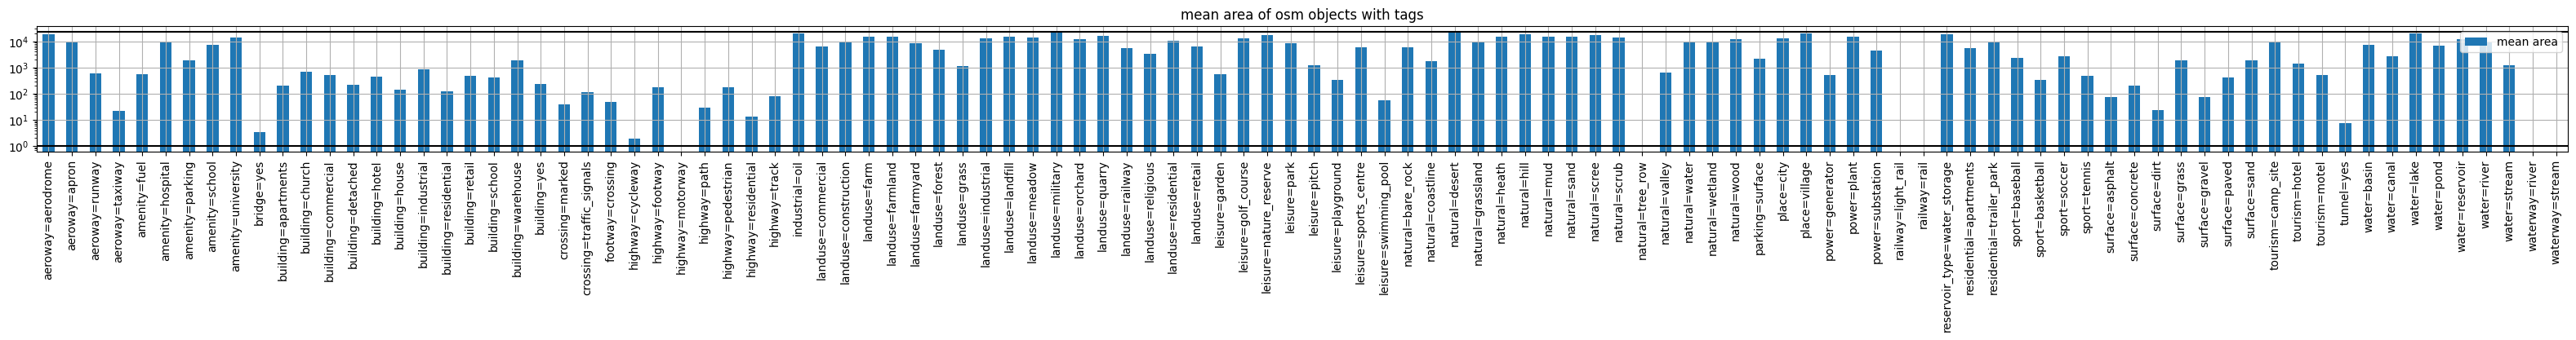

In [142]:
s100[['mean area']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('mean area of osm objects with tags')
plt.axhline(1, color='black')
plt.axhline(22500, color='black')
plt.yscale('log')


Text(0.5, 1.0, 'mean length of osm objects with tags')

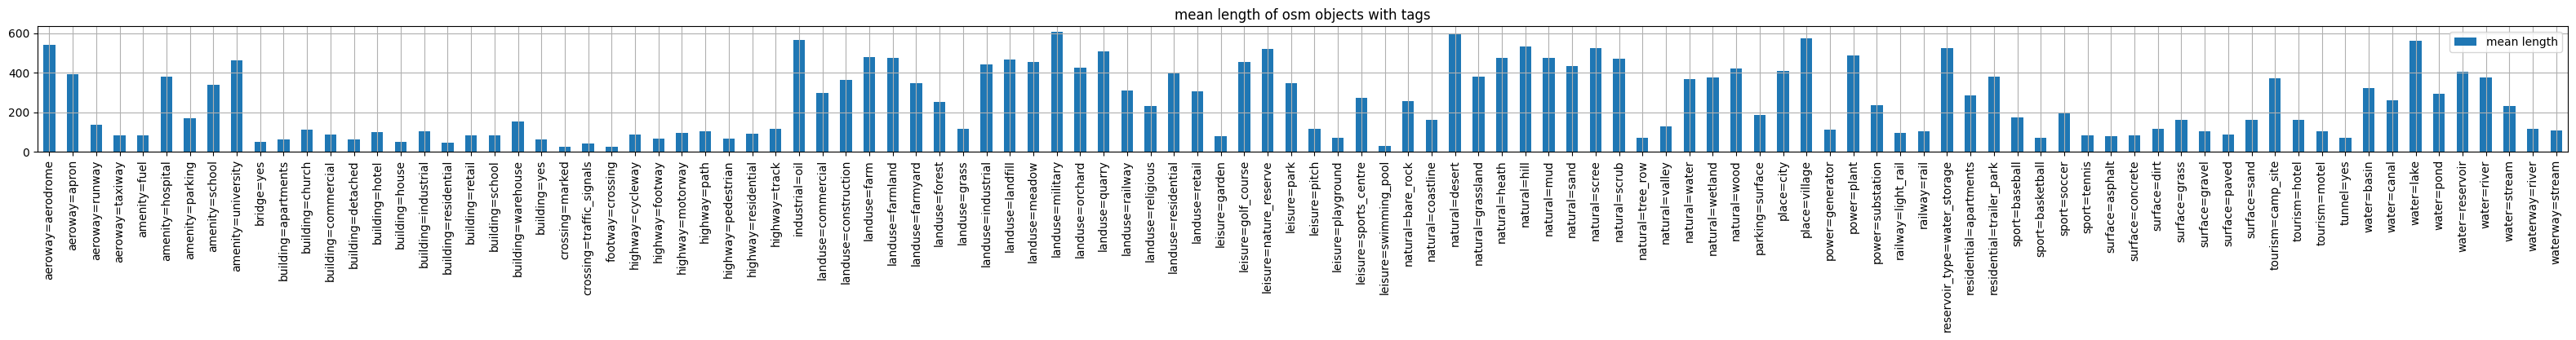

In [144]:
s100[['mean length']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('mean length of osm objects with tags')


Text(0.5, 1.0, 'mean occurrences per chip')

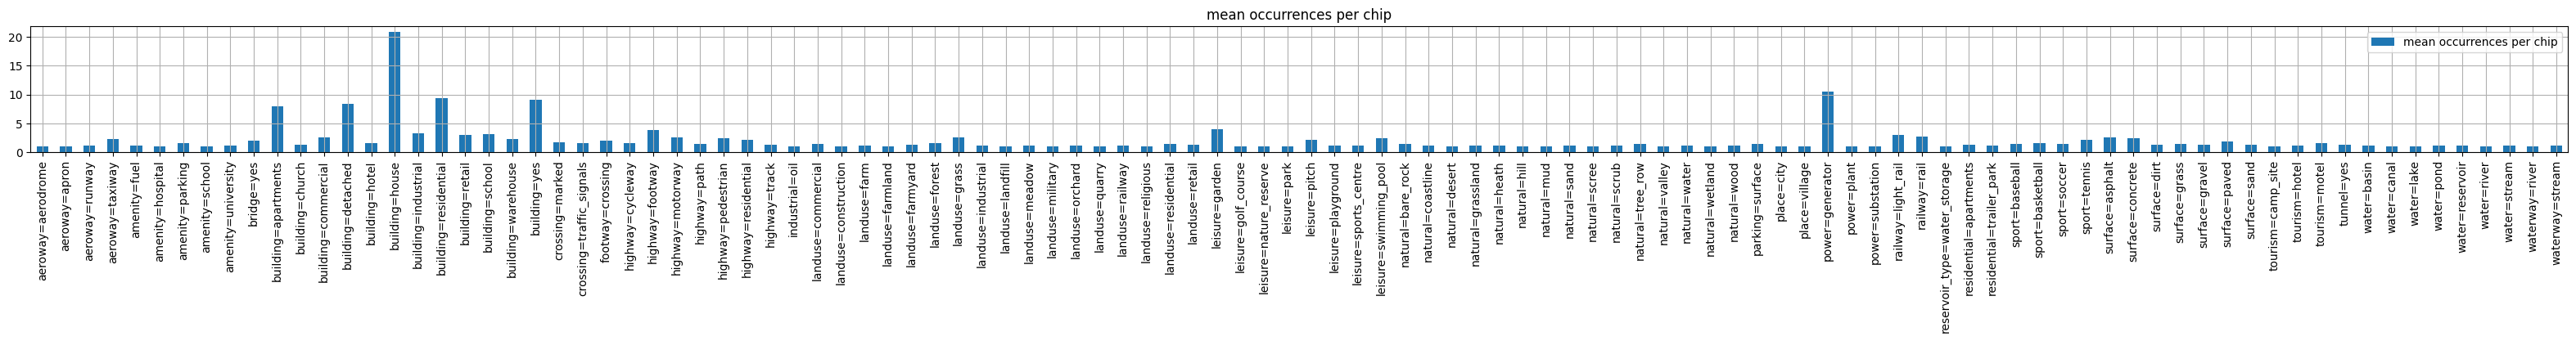

In [145]:
s100[['mean occurrences per chip']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('mean occurrences per chip')

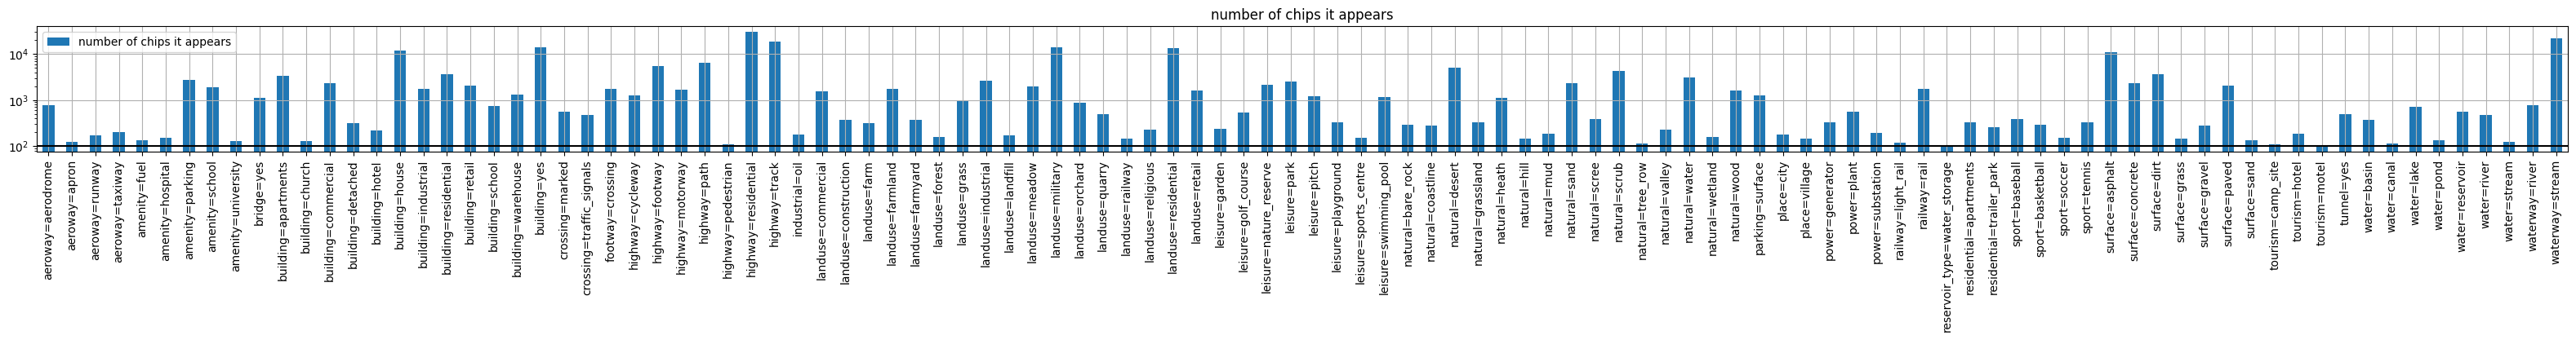

In [148]:
s100[['number of chips it appears']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('number of chips it appears')
plt.axhline(100, color="black")
plt.yscale('log')


In [31]:
c = gpd.read_parquet("/opt/data/california-naip-chips/osm/110015f9589eb.parquet")
c.explore()

In [32]:
c

,tags,geometry,kind,length,area,stags,chip_id
479,"{'highway': 'residential', 'surface': 'asphalt'}","LINESTRING (-118.79786 34.01746, -118.79781 34...",way,183.545353,0.000000,highway: residential\n<br>\nsurface: asphalt,110015f9589eb
1427,{'highway': 'service'},"LINESTRING (-118.79761 34.01718, -118.79783 34...",way,70.175244,0.000000,highway: service,110015f9589eb
1437,{'highway': 'service'},"LINESTRING (-118.79739 34.01694, -118.79722 34...",way,70.177818,0.000000,highway: service,110015f9589eb
6455,"{'highway': 'service', 'surface': 'compacted'}","MULTILINESTRING ((-118.79698 34.01717, -118.79...",way,59.871104,0.000000,highway: service\n<br>\nsurface: compacted,110015f9589eb
6492,"{'building': 'house', 'building:units': '1'}","POLYGON ((-118.79810 34.01737, -118.79810 34.0...",way,62.294824,138.169728,building: house\n<br>\nbuilding:units: 1,110015f9589eb
6510,"{'building': 'house', 'building:units': '1'}","POLYGON ((-118.79711 34.01621, -118.79699 34.0...",way,47.591106,101.418677,building: house\n<br>\nbuilding:units: 1,110015f9589eb
6894,"{'building': 'house', 'building:units': '1'}","POLYGON ((-118.79746 34.01668, -118.79760 34.0...",way,71.577268,251.442034,building: house\n<br>\nbuilding:units: 1,110015f9589eb
7084,"{'building': 'house', 'building:units': '1'}","POLYGON ((-118.79819 34.01607, -118.79803 34.0...",way,73.085669,277.585682,building: house\n<br>\nbuilding:units: 1,110015f9589eb
7110,"{'building': 'house', 'building:units': '1'}","POLYGON ((-118.79677 34.01691, -118.79681 34.0...",way,54.338725,121.715343,building: house\n<br>\nbuilding:units: 1,110015f9589eb
7174,"{'building': 'house', 'building:units': '1'}","POLYGON ((-118.79839 34.01746, -118.79838 34.0...",way,15.160215,11.802186,building: house\n<br>\nbuilding:units: 1,110015f9589eb
